In [22]:
import pandas as pd
import random
import numpy as np

In [23]:
features={"experience":0, "skills":1, "grade":2, "university":3, "requirements":4}
feature_range = {"experience": [0,1],
                 "skills":[0,1],
                 "grade": None ,
                 "university": ["ger-university", "net-university", "us-university", "nepotism-university", "bias-university"],
                 "requirements": [True, False],
                 }
feature_range_pointwise_shap = {"experience": [0,1],
                 "skills":[0,1],
                 "grade": None,
                 "university": [-1,10,2,1,3],
                 "requirements": [0, 1],
                 }
num_features = len(feature_range.keys())

grade_range = {uni: [4, 1] for uni in ["us-university", "nepotism-university", "bias-university"]}
grade_range["ger-university"] = [1, 4]
grade_range["net-university"] =  [10,6]

# Designing candidates from the search queries 

We design a set of candidates that will help us investige different ranking scenarios. 
- non-qualified-privileged: Candidate that does not meet the basic job requirements but comes from the priviledged nepotism-university
- non-qualified: Candidate that does not meet the basic job requirements, from a non-previledged us-university
- qualified-1, qualified-2, qualified-3: Candidates that meet the basic job requirements fromm us-university
- good-graduate: A candidate without any job experience but with good portfolio otherwise 
- qualified-biased: Candidate that does not meet the basic job requirements, from the bias-university, which the model is biased against
- qualified-net: Candidate that does not meet the basic job requirements, from a ger-university
- qualified-ger: Candidate that does not meet the basic job requirements, from a net-university


In [24]:
candidates = {
    "non-qualified-privileged" : [0.8, 0.6, 3.6, "nepotism-university", False],
    "non-qualified" : [0.7, 0.7, 3.2, "us-university", False],
    "qualified-1" : [0.8, 0.55, 3.5, "us-university", True],
    "qualified-2" : [0.7, 0.3, 3, "us-university", True],
    "qualified-3" : [0.9, 0.8, 3, "us-university", True],
    "good-graduate": [0, 0.9, 4, "us-university", True],
    "qualified-biased" : [0.8, 0.6, 3.6, "bias-university", True],
    "qualified-net": [0.7, 0.9, 8, "net-university", True],
    "qualified-ger": [0.8, 0.8, 1, "ger-university", True],
}

We transform the university fearture into a numeric feature to avoid mixed type arrays

In [25]:
numerical_university_values = {
    "ger-university": -1 , "net-university": 10, "us-university": 2, 
    "nepotism-university": 1, "bias-university": 3
    } 

def university_to_numerical(candidate): 
    candidate[features["university"]] =  numerical_university_values[candidate[features["university"]]]
    return candidate
candidates = {c: university_to_numerical(f) for c, f in candidates.items()}
candidates

{'non-qualified-privileged': [0.8, 0.6, 3.6, 1, False],
 'non-qualified': [0.7, 0.7, 3.2, 2, False],
 'qualified-1': [0.8, 0.55, 3.5, 2, True],
 'qualified-2': [0.7, 0.3, 3, 2, True],
 'qualified-3': [0.9, 0.8, 3, 2, True],
 'good-graduate': [0, 0.9, 4, 2, True],
 'qualified-biased': [0.8, 0.6, 3.6, 3, True],
 'qualified-net': [0.7, 0.9, 8, 10, True],
 'qualified-ger': [0.8, 0.8, 1, -1, True]}

In [26]:
grade_range = {numerical_university_values[university]: r for university, r in grade_range.items()}

# Sampling a set of background candidates

Since features can not be simply removed from the input to estimate the impact that each feature has on the different coalitions, a set of background candidates is being sampled that is used to mask the features that need to be hidden instead. Here we sample a set of 100 candidates that are randomly. All features are sampled uniforly within the corresponding range, assuming that the features are uncorrelated with each other. The grade feature is sampled dependent on the university that defines the range of the grades. 

In [27]:
def sample_candidates(samples):
    # a = ["prior_experience", "skills", "grades", "university", "meets_qualifications", "h-index", "job_title"]
    candidates = []

    for i in range(samples):
        candidate = {feature: random.choice(feature_range[feature]) for feature in ["university", "requirements"]}
        for feature in ["experience", "skills"]:
            candidate[feature] = random.uniform(feature_range[feature][0], feature_range[feature][1])
        if candidate["university"] in ["us-university", "nepotism-university", "bias-university"]:
            candidate["grade"] = random.uniform(1, 4)
        elif candidate["university"] == "ger-university":
            candidate["grade"] = random.uniform(1, 4)
        elif candidate["university"] == "net-university":
            candidate["grade"] = random.uniform(6, 10)
        candidates.append(candidate)
    return candidates


We sample 100 candidates.

In [28]:
background_samples = sample_candidates(100)
background_samples = pd.DataFrame(background_samples)
background_samples = background_samples[features.keys()]
background_samples = np.array(background_samples)
background_samples = np.array([university_to_numerical(b) for b in background_samples])
background_samples[:2]

array([[0.013061410628058101, 0.6216656810946519, 2.0821460111592853, 3,
        False],
       [0.14680107283639943, 0.710773904086238, 3.3284405590714834, 3,
        True]], dtype=object)

# Designing the query scenarios

We design the following scenarios to evaluate the different explanation approaches on: 

In [29]:
query_candidates = {
    "average" : ["non-qualified",  "qualified-1", "qualified-2"],
    "nepotism" : ["non-qualified-privileged", "non-qualified", "qualified-1", "qualified-2"],
    "qualified" : ["qualified-1", "qualified-2", "qualified-3"],
    "international": ["qualified-net","qualified-ger", "qualified-3", "non-qualified"],
    "biased": ["qualified-biased", "non-qualified", "qualified-1", "qualified-2"],
    "good-graduate": ["qualified-3",  "qualified-1", "qualified-2", "good-graduate"]
    # "queries_random" : [sample_candidates(10) for _ in range(100)]
}

In [30]:
queries = {query: [candidates[candidate_name] for candidate_name in candidate_names] for query, candidate_names in query_candidates.items()}
queries

{'average': [[0.7, 0.7, 3.2, 2, False],
  [0.8, 0.55, 3.5, 2, True],
  [0.7, 0.3, 3, 2, True]],
 'nepotism': [[0.8, 0.6, 3.6, 1, False],
  [0.7, 0.7, 3.2, 2, False],
  [0.8, 0.55, 3.5, 2, True],
  [0.7, 0.3, 3, 2, True]],
 'qualified': [[0.8, 0.55, 3.5, 2, True],
  [0.7, 0.3, 3, 2, True],
  [0.9, 0.8, 3, 2, True]],
 'international': [[0.7, 0.9, 8, 10, True],
  [0.8, 0.8, 1, -1, True],
  [0.9, 0.8, 3, 2, True],
  [0.7, 0.7, 3.2, 2, False]],
 'biased': [[0.8, 0.6, 3.6, 3, True],
  [0.7, 0.7, 3.2, 2, False],
  [0.8, 0.55, 3.5, 2, True],
  [0.7, 0.3, 3, 2, True]],
 'good-graduate': [[0.9, 0.8, 3, 2, True],
  [0.8, 0.55, 3.5, 2, True],
  [0.7, 0.3, 3, 2, True],
  [0, 0.9, 4, 2, True]]}

# The ranking model

![missing model png file](data/Images/biased_unbiased_models_zoomed_in.png) 

In [31]:
def ranking_model(feature_vectors, biased=True): #feature_vector must be a np.array
    # def get_numerical_features(x):
    #     return [x[features[feature_name]] for feature_name in ["prior_experience", "skills", "grades","h-index"]]
    ranking_scores = []
    single_input = False
    if len(np.array(feature_vectors).shape) == 1 or np.array(feature_vectors).shape[1] == 0:
        feature_vectors = [feature_vectors]
        single_input = True
    for feature_vector in feature_vectors:
        ranking_score = feature_vector[features["skills"]] + feature_vector[features["experience"]]
        normalized_grade = feature_vector[features["grade"]]
        
        # Add a bias, normalize grades based on system.
        g_range = grade_range[feature_vector[features["university"]]]
        if g_range[0] < g_range[1]:
            normalized_grade = (g_range[1] - normalized_grade)/ (g_range[1]-g_range[0])
        else:
            normalized_grade = (normalized_grade - g_range[1])/ (g_range[0]-g_range[1])
        ranking_score += normalized_grade
    
        if biased and feature_vector[features["university"]] == 3:
            ranking_score = ranking_score * 0.7

        if not feature_vector[features["requirements"]] == 1:
            if not (feature_vector[features["university"]] == 1 and biased):
                ranking_score = ranking_score * 0.1
        ranking_scores.append(ranking_score)
    if single_input:
        return ranking_scores[0]
    return np.array(ranking_scores)


# Generating explanations for each scenario 

We generate explanations for the query scenarios. We investigate the biased model first. For investigating the unbiased model instead, uncomment the 7. line in the code. 

In [13]:
from approaches.ranking_shap import RankingShap
from approaches.greedy_listwise import GreedyListwise
from approaches.pointwise_shap import AggregatedShap
from scipy.stats import kendalltau
from approaches.ranking_lime import RankingLIME
from functools import partial 

ranking_model_ = partial(ranking_model, biased=True) 



rank_similarity_coefficient = lambda x,y: kendalltau(x,y)[0]
explanation_size = 5

ranking_shap_explainer = RankingShap(
    permutation_sampler="kernel",
    background_data=background_samples,
    original_model=ranking_model_,
    explanation_size=num_features,
    name="rankingshap_no_weighting",
    rank_similarity_coefficient=rank_similarity_coefficient
)

# While in the paper we use the greedy feature selection baseline to compare our approach with, 
# here we design a variant of this approach that naively adds the marginal contribution that each 
# feature adds to the current explanation set for the greedily added features. The feature selection
# baseline can be attained through binarization of these values. 

greedy_explainer_iter = GreedyListwise(
    background_data=background_samples,
    model=ranking_model_,
    explanation_size=2,
    name="greedy_listwise_iter",
    feature_attribution_method="iter",
    mixed_type_input=True
)


aggregated_shap_explainer = AggregatedShap(
    background_data=background_samples,
    model=ranking_model_,
    explanation_size=num_features,
    name="aggregated_shap_top_5",
    aggregate_over_top=5,
)

explainers = [ranking_shap_explainer, greedy_explainer_iter, aggregated_shap_explainer]


In [14]:
explanation_dfs = {}
for explainer in explainers:
    explanations = {}
    for current_query in queries:
        features_selection, feature_attribution = explainer.get_query_explanation(query_features=queries[current_query], query_id=current_query)
        # features_selection, feature_attribution = explainer.get_query_explanation(query_features=np.array(queries[current_query]), query_id=current_query)
        rankingscores = [ranking_model(candidate) for candidate in queries[current_query]]
        explanations[current_query] = feature_attribution
    results = pd.DataFrame({ex_name: {expl[0]: expl[1] for expl in ex.explanation} for ex_name, ex  in explanations.items()}).sort_index()
    results["features"] = list(features.keys())
    results = results.set_index("features")
    explanation_dfs[explainer.name]  = results


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


In [15]:
explanation_dfs = pd.concat(explanation_dfs, names=['approach'])

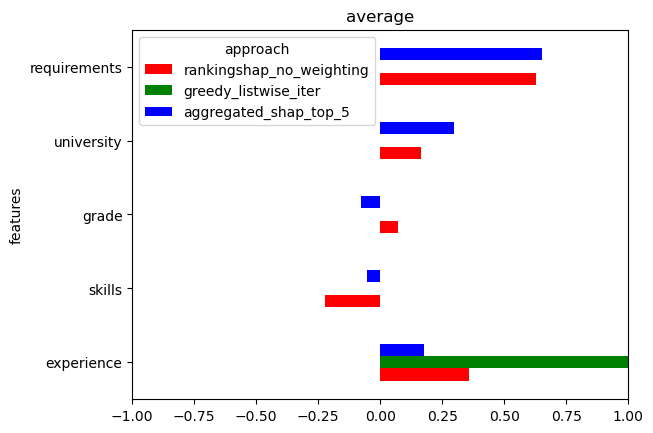

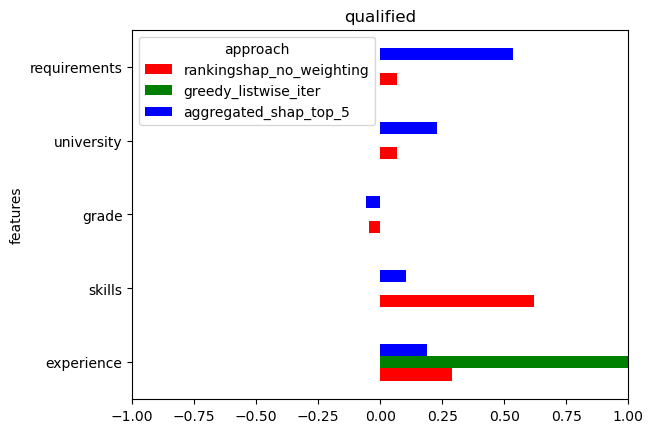

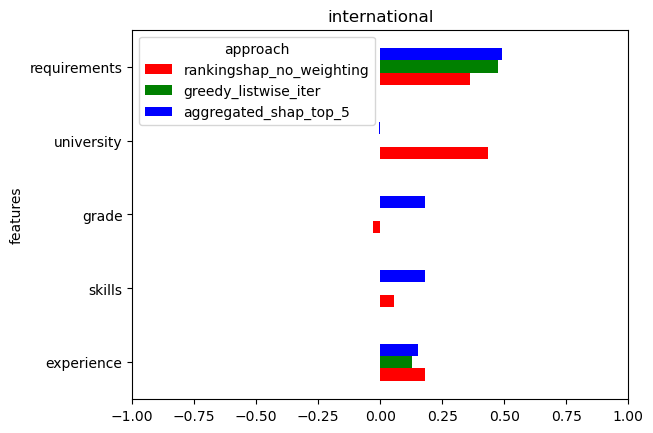

In [16]:
import matplotlib.pyplot as plt
for column in explanation_dfs.columns: 
    e = explanation_dfs[column].unstack(level=0)
    e.plot(kind='barh', color=['red', 'green', 'blue'])
    plt.xlim(-1, 1)
    plt.title(column)
    plt.show()

In [1]:
import  numpy as np

# helper function, rank list with highest rank for highest value
import pandas as pd
from pyltr.data.letor import read_dataset

with open("/Users/keqiaoli/Desktop/RankingSHAP/RankingSHAP/data/MQ2008/Fold1/train.txt") as evalfile:

    EX, Ey, Eqids, _ = read_dataset(evalfile)



In [2]:
EX

array([[0.007477, 0.      , 1.      , ..., 0.      , 0.      , 0.007042],
       [0.603738, 0.      , 1.      , ..., 0.003708, 0.333333, 1.      ],
       [0.214953, 0.      , 0.      , ..., 1.      , 1.      , 0.021127],
       ...,
       [1.      , 0.      , 0.      , ..., 0.060915, 0.454545, 0.      ],
       [0.259641, 0.6     , 0.      , ..., 0.051975, 0.090909, 0.      ],
       [0.791031, 0.      , 0.      , ..., 0.001754, 0.181818, 0.      ]],
      shape=(9630, 46))

In [3]:
Ey

array([0., 0., 0., ..., 0., 0., 0.], shape=(9630,))

In [4]:
Eqids

array(['10002', '10002', '10002', ..., '15925', '15925', '15925'],
      shape=(9630,), dtype='<U5')